# Requirements

In [ ]:
import pandas as pd
import json
import numpy as np
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu
from collections import Counter
from scipy.spatial import KDTree
from sklearn.cluster import MeanShift
from scipy.spatial.distance import euclidean
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

## Result Read

In [ ]:
def read_results(file_path):
    data = []  # Initialize an empty list to store the JSON objects
    with open(file_path, 'r') as file:
        for line in file:
            try:
                # Replace single quotes with double quotes and attempt to parse as JSON
                json_object = json.loads(line.replace("'", '"').replace("nan", "-1"))
                data.append(json_object)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e} in line: {line}")
    # Convert the list into a pandas DataFrame

    df = pd.DataFrame(data)
    df = df.replace(-1, None)
    return df



## Data Operations

In [ ]:
def scale_seeds(seeds, scaler):
    return scaler.transform(seeds)

In [ ]:
def prepare_data(fits_path, start_velocity, end_velocity, use_otsu=True, otsu_mult_factor=1.0, scaling_method='standard'):

    hdul = fits.open(fits_path)
    data_list = []

    # Read image data into data_list
    for i in range(500):
        image = hdul[0].data[i]
        data_list.append(image)

    # Compute Otsu threshold if required
    if use_otsu:
        all_pixel_values = []
        for z, image in enumerate(data_list):
            velocity = -175. + z * 0.5
            if start_velocity <= velocity <= end_velocity:
                min_val = np.nanmin(image)
                image_no_nan = np.where(np.isnan(image), min_val, image)
                all_pixel_values.extend(image_no_nan.ravel())
        global_thresh = threshold_otsu(np.array(all_pixel_values))
        thresh = global_thresh * otsu_mult_factor
    else:
        thresh = 1.7  # Default threshold if not using Otsu

    # Create the dataset
    dataset = []
    for z, image in enumerate(data_list):
        for x in range(image.shape[0]):
            for y in range(image.shape[1]):
                pixel_value = image[x, y]
                if not np.isnan(pixel_value) and (pixel_value > thresh):
                    if start_velocity <= (-175. + z * 0.5) <= end_velocity:
                        dataset.append([x, y, (-175. + z * 0.5), pixel_value])

    dataset = np.array(dataset)

    # Convert dataset to DataFrame
    dataset_df = pd.DataFrame(dataset, columns=['x', 'y', 'velocity', 'pixel_value'])

    # Choose the scaling method
    if scaling_method == 'standard':
        scaler = StandardScaler()
    elif scaling_method == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scaling_method. Choose either 'standard' or 'minmax'")

    # Scale the dataset
    scaled_dataset = scaler.fit_transform(dataset)

    # Convert scaled dataset to DataFrame
    scaled_df = pd.DataFrame(scaled_dataset, columns=['x', 'y', 'velocity', 'pixel_value'])

    return scaled_df, scaler, dataset_df

In [108]:
fits_path = "/content/drive/MyDrive/DSH_RESULTS/4U1630_12CO.fits"

hdul = fits.open(fits_path)
data_list = []

# Read image data into data_list
for i in range(500):
    image = hdul[0].data[i]
    data_list.append(image)

# Create the dataset
dataset = []
for z, image in enumerate(data_list):
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            pixel_value = image[x, y]
            if -130 <= (-175. + z * 0.5) <= -10:
                dataset.append([x, y, (-175. + z * 0.5), pixel_value])

dataset = np.array(dataset)

# Convert dataset to DataFrame
dataset_df = pd.DataFrame(dataset, columns=['x', 'y', 'velocity', 'pixel_value'])
velocity_sum = dataset_df.groupby('velocity')['pixel_value'].sum()

# Find min and max summed pixel values
min_pixel_sum = velocity_sum.min()
max_pixel_sum = velocity_sum.max()

min_pixel_sum, max_pixel_sum

(3.292444457284546, 8442.390370830894)

In [118]:
def post_process_data_optimized(df):
    # Convert relevant columns to numpy arrays for faster processing
    labels = df['label'].to_numpy()
    pixel_values = df['pixel_value'].to_numpy()

    rows = []
    for i in range(len(labels)):
        label = labels[i]
        pixel_value = pixel_values[i]

        if isinstance(label, (int, np.integer)):
            rows.append(df.iloc[i])
        elif isinstance(label, list):
            if len(label) == 1 and isinstance(label[0], (int, np.integer)):
                new_row = df.iloc[i].copy()
                new_row['label'] = label[0]
                rows.append(new_row)
            else:
                if all(isinstance(item, tuple) and len(item) == 2 for item in label):
                    label_probs = label
                    new_labels, probs = zip(*label_probs)
                    new_pixel_values = np.multiply(pixel_value, probs)

                    for j in range(len(new_labels)):
                        new_row = df.iloc[i].copy()
                        new_row['label'] = new_labels[j]
                        new_row['pixel_value'] = new_pixel_values[j]
                        rows.append(new_row)
                else:
                    print(f"Warning: Label at index {i} is not in the proper format: {label}")
        else:
            print(f"Warning: Label at index {i} is not in the proper format: {label}")

    redistributed_df = pd.DataFrame(rows)

    # Using groupby and sum with numpy for faster processing
    pixel_sums_df = redistributed_df.groupby(['label', 'velocity'], as_index=False).agg({'pixel_value': 'sum'})

    # Vectorized normalization with numpy
    min_pixel_sum = 3.292444457284546
    max_pixel_sum = 8442.390370830894
    norm_range = [0, 3.2428885]
    pixel_sums_df['normalized_pixel_sum'] = norm_range[0] + np.divide(np.multiply(np.subtract(pixel_sums_df['pixel_value'], min_pixel_sum), (norm_range[1] - norm_range[0])), (max_pixel_sum - min_pixel_sum))

    return pixel_sums_df

## Clustering


In [ ]:
seeds_list = [ [[ 2, 18, -20, 16.267826 ]],

               [[36, 28, -117, 4.000822],
                [3, 34, -114, 44.590847	]],

                [[2, 35, -100,   5.597802],
                 [34, 22, -105,  6.21070 ],
                 [24, 2, -109,  6.593767 ]],

               [[5, 2, -80, 11.789562	  ],
                [18, 95, -73, 3.884139	  ],
                [26, 40, -68, 10.8933067 ],
                [12, 14, -61, 4.530908		],
                [6, 13, -56, 4.385234    ]],

               [[13, 42, -47, 4.081348 ],
                [11, 43, -42, 6.984776	],
                [20, 27, -39, 2.355332 ],
                [12, 1, -35, 2.021111  ]]]

intervals_list = [[-25, -15],[-121, -111.5],[-112, -95],[-95, -52,],[-53, -30]]

otsu_factor_list = [0.2,0.3,0.5,0.25,0.6]

### MS

In [ ]:
def multi_label_mean_shift(X, seeds, bandwidths, epsilon=1e-3, max_iter=100,
                           weighting_method='inverse_distance', alpha=0.6, beta=0.1, fweight_velocity=1,fweight_pixel_value=1,fweight_xy=1):


    C, _, A = mean_shift_clustering(X, seeds, bandwidths, epsilon, max_iter, fweight_velocity, fweight_pixel_value,fweight_xy)

    B = calculate_B_matrix(A, method=weighting_method)

    # Initialize labels list
    labels = []

    # Calculate max probabilities and their indices
    max_probs = np.max(B, axis=1)
    max_indices = np.argmax(B, axis=1)

    # Mask for single label assignment
    single_label_mask = max_probs >= alpha

    # Single label assignment
    single_labels = max_indices[single_label_mask]
    single_labels_list = np.expand_dims(single_labels, axis=1).tolist()
    labels.extend(single_labels_list)

    # Multiple label assignment
    multi_label_rows = B[~single_label_mask, :]
    above_beta_mask = multi_label_rows >= beta
    below_beta_mask = ~above_beta_mask

    sum_below_beta = np.sum(multi_label_rows * below_beta_mask, axis=1, keepdims=True)
    sum_above_beta = np.sum(multi_label_rows * above_beta_mask, axis=1, keepdims=True)
    redistributed_probs = (multi_label_rows * above_beta_mask) + (multi_label_rows * above_beta_mask) / (sum_above_beta + 1e-10) * sum_below_beta

    # Normalizing redistributed probabilities
    total_prob = np.sum(redistributed_probs, axis=1, keepdims=True)
    normalized_probs = redistributed_probs / total_prob

    # Iterating only through the necessary indices and rows for final label assignment
    row_indices, col_indices = np.nonzero(above_beta_mask)
    unique_rows = np.unique(row_indices)

    # Building a mapping from row index to relevant column indices
    row_to_cols_map = {row: col_indices[row_indices == row] for row in unique_rows}

    # Using list comprehension to create labels
    labels.extend([list(zip(row_to_cols_map[row], normalized_probs[row, row_to_cols_map[row]])) for row in unique_rows])

    all_labels = []

    # Iterate through the labels list and concatenate single and multi-labels
    for label in labels:
        if isinstance(label, int):
            all_labels.append([label])
        elif isinstance(label, list):
            all_labels.append(label)

    # Create a DataFrame to store the labels
    labels_df = pd.DataFrame({'label': all_labels})


    return labels_df

def mean_shift_clustering(X, seeds, bandwidths, epsilon=1e-3, max_iter=10, fweight_velocity=1, fweight_pixel_value=1, fweight_xy=1):

    weight_velocity = fweight_velocity
    weight_pixel_value = fweight_pixel_value
    weight_xy = fweight_xy

    # Weight the features
    X_weighted = np.copy(X)
    seeds_weighted = np.copy(seeds)

    # weighting all 4 features
    X_weighted[:, 0] *= weight_xy
    seeds_weighted[:, 0] *= weight_xy

    X_weighted[:, 1] *= weight_xy
    seeds_weighted[:, 1] *= weight_xy

    X_weighted[:, 2] *= weight_velocity
    seeds_weighted[:, 2] *= weight_velocity

    X_weighted[:, 3] *= weight_pixel_value
    seeds_weighted[:, 3] *= weight_pixel_value


    # Initialize cluster centers as seeds
    C = np.copy(seeds_weighted)

    # Initialize distance matrix A
    n_samples, n_features = X.shape
    n_clusters = len(seeds)
    A = np.zeros((n_samples, n_clusters))


    # Main loop for each seed point
    for i in range(n_clusters):
        s_i = seeds_weighted[i]
        b_i = bandwidths[i]

        # Using a NumPy array for efficient distance calculations
        X_weighted_np = np.array(X_weighted)

        for _ in range(max_iter):
            #calculate distances and filter neighbors within bandwidth
            distances = distance.cdist([s_i], X_weighted_np, 'euclidean').flatten()
            neighbors_mask = distances < b_i
            N = X_weighted_np[neighbors_mask]

            if len(N) == 0:
                break

            # Calculate the shift vector M using vectorized operations
            weights = np.exp(-np.sum((N - s_i)**2, axis=1) / (2 * b_i**2))
            M = np.sum(weights[:, None] * N, axis=0) / np.sum(weights)

            # Check for convergence using efficient distance calculation
            if distance.euclidean(s_i, M) < epsilon:
                break

            # Update the seed point
            s_i = M

        # Update cluster center
        C[i] = s_i


    # Fill distance matrix A and assign clusters
    labels = np.zeros(n_samples, dtype=int)
    # compute all distances using vectorized operations
    A = distance.cdist(X_weighted, C, 'euclidean')
    # Assign clusters by finding the index of the minimum distance for each sample
    labels = np.argmin(A, axis=1)


    # Revert the weighting on the final cluster centers for interpretability
    C[:, 0] /= weight_xy
    C[:, 1] /= weight_xy
    C[:, 2] /= weight_velocity
    C[:, 3] /= weight_pixel_value


    return C, labels, A


def calculate_B_matrix(A, method='inverse_distance'):

    n_samples, n_clusters = A.shape
    B = np.zeros((n_samples, n_clusters))

    if method == 'inverse_distance':
        B = 1 / A
        row_sums = B.sum(axis=1, keepdims=True)
        B /= row_sums

    elif method == 'gaussian_kernel':
        B = np.exp(-A ** 2)
        row_sums = B.sum(axis=1, keepdims=True)
        zero_sum_mask = (row_sums == 0).flatten()
        row_sums[zero_sum_mask] = 1  # Prevent division by zero
        B /= row_sums
        B[zero_sum_mask, :] = 1 / n_clusters  # Uniform distribution for zero-sum rows

    elif method == 'softmax':
        B = np.exp(-A)
        row_sums = B.sum(axis=1, keepdims=True)
        B /= row_sums

    else:
        raise ValueError("Invalid method. Supported methods are 'inverse_distance', 'gaussian_kernel', 'softmax'")

    return B

In [40]:
def MS(CO,parameters):

    if CO == "12CO":
        fits_path = "/content/drive/MyDrive/DSH_RESULTS/4U1630_12CO.fits"
    elif CO == "13CO":
        fits_path = "/content/drive/MyDrive/DSH_RESULTS/4U1630_13CO.fits"

    #INTERVAL1

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[0][0], intervals_list[0][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[0],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[0], scaler)

    labels = multi_label_mean_shift(scaled_dataset, scaled_seeds,
                                             [0.1], alpha=0.7, beta=0.2,
                                              fweight_velocity=1, fweight_pixel_value=1,
                                                fweight_xy=1)

    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df1 = post_process_data_optimized(result_df)

    unique_values = agg_df1['label'].nunique()
    print(unique_values)

    #INTERVAL2

    bw = parameters[3]["bandwidths"]
    alpha = parameters[3]["alpha"]
    beta = parameters[3]["beta"]
    vw = parameters[3]["velocity_weight"]
    pw = parameters[3]["pixel_value_weight"]
    xyw = parameters[3]["xy_weight"]

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[1][0], intervals_list[1][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[1],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[1], scaler)

    labels = multi_label_mean_shift(scaled_dataset, scaled_seeds,
                                    bw,alpha=alpha, beta=beta,
                                    fweight_velocity=vw, fweight_pixel_value=pw,
                                    fweight_xy=xyw)

    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df2 = post_process_data_optimized(result_df)

    unique_values = agg_df2['label'].nunique()
    print(unique_values)


    #INTERVAL3

    bw = parameters[2]["bandwidths"]
    alpha = parameters[2]["alpha"]
    beta = parameters[2]["beta"]
    vw = parameters[2]["velocity_weight"]
    pw = parameters[2]["pixel_value_weight"]
    xyw = parameters[2]["xy_weight"]

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[2][0], intervals_list[2][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[2],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[2], scaler)

    labels = multi_label_mean_shift(scaled_dataset, scaled_seeds,
                                    bw,alpha=alpha, beta=beta,
                                    fweight_velocity=vw, fweight_pixel_value=pw,
                                    fweight_xy=xyw)

    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df3 = post_process_data_optimized(result_df)

    unique_values = agg_df3['label'].nunique()
    print(unique_values)


    #INTERVAL4

    bw = parameters[1]["bandwidths"]
    alpha = parameters[1]["alpha"]
    beta = parameters[1]["beta"]
    vw = parameters[1]["velocity_weight"]
    pw = parameters[1]["pixel_value_weight"]
    xyw = parameters[1]["xy_weight"]

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[3][0], intervals_list[3][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[3],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[3], scaler)

    labels = multi_label_mean_shift(scaled_dataset, scaled_seeds,
                                    bw,alpha=alpha, beta=beta,
                                    fweight_velocity=vw, fweight_pixel_value=pw,
                                    fweight_xy=xyw)

    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df4 = post_process_data_optimized(result_df)

    unique_values = agg_df4['label'].nunique()
    print(unique_values)


    #INTERVAL5

    bw = parameters[0]["bandwidths"]
    alpha = parameters[0]["alpha"]
    beta = parameters[0]["beta"]
    vw = parameters[0]["velocity_weight"]
    pw = parameters[0]["pixel_value_weight"]
    xyw = parameters[0]["xy_weight"]

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[4][0], intervals_list[4][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[4],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[4], scaler)

    labels = multi_label_mean_shift(scaled_dataset, scaled_seeds,
                                    bw,alpha=alpha, beta=beta,
                                    fweight_velocity=vw, fweight_pixel_value=pw,
                                    fweight_xy=xyw)

    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df5 = post_process_data_optimized(result_df)

    unique_values = agg_df5['label'].nunique()
    print(unique_values)


    max_label1 = agg_df1['label'].max() + 1
    max_label2 = agg_df2['label'].max() + 1 + max_label1
    max_label3 = agg_df3['label'].max() + 1 + max_label2
    max_label4 = agg_df4['label'].max() + 1 + max_label3

    # Adjust the 'label' column in each dataframe
    agg_df2['label'] += max_label1
    agg_df3['label'] += max_label2
    agg_df4['label'] += max_label3
    agg_df5['label'] += max_label4

    # Concatenate all dataframes
    concatenated_df = pd.concat([agg_df1, agg_df2, agg_df3, agg_df4, agg_df5], ignore_index=True)

    return concatenated_df




### GMM

In [ ]:
def cluster_with_GMM(data, n_components, tol=0.001, weights_init=None, means_init=None, alpha=0.5, beta=0.3):
    """
    Cluster data using a Gaussian Mixture Model with advanced probability assignment.

    Parameters:
    data (array-like): The input data to cluster.
    n_components (int): The number of mixture components.
    covariance_type (str): The type of covariance parameters to use.
    tol (float): Convergence threshold.
    weights_init (array-like, optional): Initial weights for each component.
    means_init (array-like, optional): Initial means for each component.
    alpha (float): Threshold for single label assignment.
    beta (float): Threshold for multiple label assignment.

    Returns:
    DataFrame: A DataFrame with the assigned labels for each data point.
    """

    # Create GMM model with specified parameters
    gmm = GaussianMixture(n_components=n_components,
                          tol=tol,
                          weights_init=weights_init,
                          means_init=means_init)

    # Fit the model to the data
    gmm.fit(data)

    # Get probabilistic assignments
    B = gmm.predict_proba(data)

    # Initialize labels list
    labels = []

    for probs in B:
        max_prob = np.max(probs)
        if max_prob >= alpha:
            # Single label assignment
            labels.append(np.argmax(probs))
        else:
            # Multiple label assignment
            mask = probs >= beta
            if np.sum(mask) > 0:
                # Redistribute probabilities
                redistributed_probs = probs[mask]
                sum_redistributed_probs = np.sum(redistributed_probs)
                normalized_probs = redistributed_probs / sum_redistributed_probs
                labels.append(list(zip(np.nonzero(mask)[0], normalized_probs)))
            else:
                # No label meets the criteria, assign to the max probability label
                labels.append([np.argmax(probs)])

    # Create a DataFrame to store the labels
    labels_df = pd.DataFrame({'label': labels})

    return labels_df

In [ ]:
def GMM(CO,parameters):

    if CO == "12CO":
        fits_path = "/content/drive/MyDrive/DSH_RESULTS/4U1630_12CO.fits"
    elif CO == "13CO":
        fits_path = "/content/drive/MyDrive/DSH_RESULTS/4U1630_13CO.fits"

    #INTERVAL1

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[0][0], intervals_list[0][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[0],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[0], scaler)

    labels = cluster_with_GMM(scaled_dataset, len(scaled_seeds), 0.1, [1], scaled_seeds, 0.7, 0.2)


    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df1 = post_process_data_optimized(result_df)


    #INTERVAL2

    wghts = parameters[3]["weights"]
    alpha = parameters[3]["alpha"]
    beta = parameters[3]["beta"]
    tol = parameters[3]["tol"]

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[1][0], intervals_list[1][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[1],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[1], scaler)

    labels = cluster_with_GMM(scaled_dataset, len(scaled_seeds), tol, wghts, scaled_seeds, alpha, beta)


    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df2 = post_process_data_optimized(result_df)


    #INTERVAL3

    wghts = parameters[2]["weights"]
    alpha = parameters[2]["alpha"]
    beta = parameters[2]["beta"]
    tol = parameters[2]["tol"]

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[2][0], intervals_list[2][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[2],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[2], scaler)

    labels = cluster_with_GMM(scaled_dataset, len(scaled_seeds), tol, wghts, scaled_seeds, alpha, beta)

    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df3 = post_process_data_optimized(result_df)


    #INTERVAL4

    wghts = parameters[1]["weights"]
    alpha = parameters[1]["alpha"]
    beta = parameters[1]["beta"]
    tol = parameters[1]["tol"]

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[3][0], intervals_list[3][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[3],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[3], scaler)

    labels = cluster_with_GMM(scaled_dataset, len(scaled_seeds), tol, wghts, scaled_seeds, alpha, beta)

    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df4 = post_process_data_optimized(result_df)


    #INTERVAL5

    wghts = parameters[0]["weights"]
    alpha = parameters[0]["alpha"]
    beta = parameters[0]["beta"]
    tol = parameters[0]["tol"]

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[4][0], intervals_list[4][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[4],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[4], scaler)

    labels = cluster_with_GMM(scaled_dataset, len(scaled_seeds), tol, wghts, scaled_seeds, alpha, beta)

    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df5 = post_process_data_optimized(result_df)


    max_label1 = agg_df1['label'].max() + 1
    max_label2 = agg_df2['label'].max() + 1 + max_label1
    max_label3 = agg_df3['label'].max() + 1 + max_label2
    max_label4 = agg_df4['label'].max() + 1 + max_label3

    # Adjust the 'label' column in each dataframe
    agg_df2['label'] += max_label1
    agg_df3['label'] += max_label2
    agg_df4['label'] += max_label3
    agg_df5['label'] += max_label4

    # Concatenate all dataframes
    concatenated_df = pd.concat([agg_df1, agg_df2, agg_df3, agg_df4, agg_df5], ignore_index=True)

    return concatenated_df

### GMMwD

In [ ]:
def cluster_with_GMMwD(data, n_components, DP=5, alpha=0.5, beta=0.3):
    """
    Cluster data using a Gaussian Mixture Model with advanced probability assignment.

    Parameters:
    data (array-like): The input data to cluster.
    n_components (int): The number of mixture components.
    covariance_type (str): The type of covariance parameters to use.
    tol (float): Convergence threshold.
    weights_init (array-like, optional): Initial weights for each component.
    means_init (array-like, optional): Initial means for each component.
    alpha (float): Threshold for single label assignment.
    beta (float): Threshold for multiple label assignment.

    Returns:
    DataFrame: A DataFrame with the assigned labels for each data point.
    """
    # Creating the model with Dirichlet process and initial parameters
    bgmm = BayesianGaussianMixture(n_components=n_components,
                                covariance_type='diag',
                                weight_concentration_prior_type='dirichlet_process',
                                weight_concentration_prior=DP)
    bgmm.fit(data)

    B = bgmm.predict_proba(data)

    # Initialize labels list
    labels = []

    for probs in B:
        max_prob = np.max(probs)
        if max_prob >= alpha:
            # Single label assignment
            labels.append(np.argmax(probs))
        else:
            # Multiple label assignment
            mask = probs >= beta
            if np.sum(mask) > 0:
                # Redistribute probabilities
                redistributed_probs = probs[mask]
                sum_redistributed_probs = np.sum(redistributed_probs)
                normalized_probs = redistributed_probs / sum_redistributed_probs
                labels.append(list(zip(np.nonzero(mask)[0], normalized_probs)))
            else:
                # No label meets the criteria, assign to the max probability label
                labels.append([np.argmax(probs)])

    # Create a DataFrame to store the labels
    labels_df = pd.DataFrame({'label': labels})

    return labels_df

In [ ]:
def GMMwD(CO,parameters):

    if CO == "12CO":
        fits_path = "D:\\research\\DSH\\4U1630_12CO.fits"
    elif CO == "13CO":
        fits_path = "D:\\research\\DSH\\4U1630_13CO.fits"

    #INTERVAL1

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[0][0], intervals_list[0][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[0],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[0], scaler)

    labels = cluster_with_GMMwD(scaled_dataset, len(scaled_seeds), 5, 0.7, 0.2)

    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df1 = post_process_data_optimized(result_df)

    #INTERVAL2

    DP = parameters[3]["DP"]
    alpha = parameters[3]["alpha"]
    beta = parameters[3]["beta"]

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[1][0], intervals_list[1][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[1],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[1], scaler)

    labels = cluster_with_GMMwD(scaled_dataset, len(scaled_seeds), DP, alpha, beta)


    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df2 = post_process_data_optimized(result_df)


    #INTERVAL3

    DP = parameters[2]["DP"]
    alpha = parameters[2]["alpha"]
    beta = parameters[2]["beta"]

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[2][0], intervals_list[2][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[2],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[2], scaler)

    labels = cluster_with_GMMwD(scaled_dataset, len(scaled_seeds), DP, alpha, beta)

    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df3 = post_process_data_optimized(result_df)


    #INTERVAL4

    DP = parameters[1]["DP"]
    alpha = parameters[1]["alpha"]
    beta = parameters[1]["beta"]

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[3][0], intervals_list[3][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[3],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[3], scaler)

    labels = cluster_with_GMMwD(scaled_dataset, len(scaled_seeds), DP, alpha, beta)

    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df4 = post_process_data_optimized(result_df)


    #INTERVAL5

    DP = parameters[0]["DP"]
    alpha = parameters[0]["alpha"]
    beta = parameters[0]["beta"]

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[4][0], intervals_list[4][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[4],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[4], scaler)

    labels = cluster_with_GMMwD(scaled_dataset, len(scaled_seeds), DP, alpha, beta)

    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df5 = post_process_data_optimized(result_df)


    max_label1 = agg_df1['label'].max() + 1
    max_label2 = agg_df2['label'].max() + 1 + max_label1
    max_label3 = agg_df3['label'].max() + 1 + max_label2
    max_label4 = agg_df4['label'].max() + 1 + max_label3

    # Adjust the 'label' column in each dataframe
    agg_df2['label'] += max_label1
    agg_df3['label'] += max_label2
    agg_df4['label'] += max_label3
    agg_df5['label'] += max_label4

    # Concatenate all dataframes
    concatenated_df = pd.concat([agg_df1, agg_df2, agg_df3, agg_df4, agg_df5], ignore_index=True)

    return concatenated_df

### GMMwDwFW

In [ ]:
def cluster_with_GMMwDwFW(data, n_components, DP=5, alpha=0.5, beta=0.3, w=1, v=1, xy=1):
    """
    Cluster data using a Gaussian Mixture Model with advanced probability assignment.

    Parameters:
    data (array-like): The input data to cluster.
    n_components (int): The number of mixture components.
    covariance_type (str): The type of covariance parameters to use.
    tol (float): Convergence threshold.
    weights_init (array-like, optional): Initial weights for each component.
    means_init (array-like, optional): Initial means for each component.
    alpha (float): Threshold for single label assignment.
    beta (float): Threshold for multiple label assignment.

    Returns:
    DataFrame: A DataFrame with the assigned labels for each data point.
    """

    # Weight the features
    X_weighted = np.copy(data)

    # weighting all 4 features
    X_weighted[:, 0] *= xy
    X_weighted[:, 1] *= xy
    X_weighted[:, 2] *= w
    X_weighted[:, 3] *= v

    # Creating the model with Dirichlet process and initial parameters
    bgmm = BayesianGaussianMixture(n_components=n_components,
                                covariance_type='diag',
                                weight_concentration_prior_type='dirichlet_process',
                                weight_concentration_prior=DP)
    bgmm.fit(X_weighted)

    B = bgmm.predict_proba(data)

    # Initialize labels list
    labels = []

    for probs in B:
        max_prob = np.max(probs)
        if max_prob >= alpha:
            # Single label assignment
            labels.append(np.argmax(probs))
        else:
            # Multiple label assignment
            mask = probs >= beta
            if np.sum(mask) > 0:
                # Redistribute probabilities
                redistributed_probs = probs[mask]
                sum_redistributed_probs = np.sum(redistributed_probs)
                normalized_probs = redistributed_probs / sum_redistributed_probs
                labels.append(list(zip(np.nonzero(mask)[0], normalized_probs)))
            else:
                # No label meets the criteria, assign to the max probability label
                labels.append([np.argmax(probs)])

    # Create a DataFrame to store the labels
    labels_df = pd.DataFrame({'label': labels})

    return labels_df

In [33]:
def GMMwDwFW(CO,parameters):
    if CO == "12CO":
        fits_path = "/content/drive/MyDrive/DSH_RESULTS/4U1630_12CO.fits"
    elif CO == "13CO":
        fits_path = "/content/drive/MyDrive/DSH_RESULTS/4U1630_13CO.fits"

    #INTERVAL1

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[0][0], intervals_list[0][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[0],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[0], scaler)

    labels = cluster_with_GMMwDwFW(scaled_dataset, len(scaled_seeds), 5,
                               0.7, 0.2, 1, 1, 1)


    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df1 = post_process_data_optimized(result_df)

    #INTERVAL2

    DP = parameters[3]["DP"]
    alpha = parameters[3]["alpha"]
    beta = parameters[3]["beta"]
    vw = parameters[3]["velocity_weight"]
    pw = parameters[3]["pixel_value_weight"]
    xyw = parameters[3]["xy_weight"]

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[1][0], intervals_list[1][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[1],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[1], scaler)

    labels = cluster_with_GMMwDwFW(scaled_dataset, len(scaled_seeds), DP,
                               alpha, beta, vw, pw, xyw)

    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df2 = post_process_data_optimized(result_df)


    #INTERVAL3

    DP = parameters[2]["DP"]
    alpha = parameters[2]["alpha"]
    beta = parameters[2]["beta"]
    vw = parameters[2]["velocity_weight"]
    pw = parameters[2]["pixel_value_weight"]
    xyw = parameters[2]["xy_weight"]

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[2][0], intervals_list[2][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[2],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[2], scaler)

    labels = cluster_with_GMMwDwFW(scaled_dataset, len(scaled_seeds), DP,
                               alpha, beta, vw, pw, xyw)

    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df3 = post_process_data_optimized(result_df)


    #INTERVAL4

    DP = parameters[1]["DP"]
    alpha = parameters[1]["alpha"]
    beta = parameters[1]["beta"]
    vw = parameters[1]["velocity_weight"]
    pw = parameters[1]["pixel_value_weight"]
    xyw = parameters[1]["xy_weight"]

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[3][0], intervals_list[3][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[3],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[3], scaler)

    labels = cluster_with_GMMwDwFW(scaled_dataset, len(scaled_seeds), DP,
                               alpha, beta, vw, pw, xyw)

    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df4 = post_process_data_optimized(result_df)


    #INTERVAL5

    DP = parameters[0]["DP"]
    alpha = parameters[0]["alpha"]
    beta = parameters[0]["beta"]
    vw = parameters[0]["velocity_weight"]
    pw = parameters[0]["pixel_value_weight"]
    xyw = parameters[0]["xy_weight"]

    scaled_dataset, scaler, original_dataset = prepare_data(fits_path, intervals_list[4][0], intervals_list[4][1],
                                                             use_otsu=True, otsu_mult_factor=otsu_factor_list[4],
                                                               scaling_method='standard')
    scaled_seeds = scale_seeds(seeds_list[4], scaler)

    labels = cluster_with_GMMwDwFW(scaled_dataset, len(scaled_seeds), DP,
                               alpha, beta, vw, pw, xyw)

    if len(original_dataset) == len(labels):
        result_df = pd.concat([original_dataset, labels], axis=1)
    else:
        print("Number of rows in df1 and df2 do not match.")
        exit

    agg_df5 = post_process_data_optimized(result_df)


    # Adjust the 'label' column in each dataframe
    agg_df2['label'] += 1
    agg_df3['label'] += 3
    agg_df4['label'] += 6
    agg_df5['label'] += 11

    # Concatenate all dataframes
    concatenated_df = pd.concat([agg_df1, agg_df2, agg_df3, agg_df4, agg_df5], ignore_index=True)

    return concatenated_df

## Visulization

In [135]:
gaussian_parameters = [[0.31327064580350383, -117.0, 3.15],
 [0.20894931421944332, -114.0, 2.5],
 [0.4298328475778421, -109.0, 3.0],
 [0.7048214103030962, -105.5, 3.0],
 [0.7551411564937404, -99.5, 4.0],
 [3.2401527428683927, -80.0, 9.0],
 [0.52, -74.0, 4.0],
 [0.6189744061235801, -67.5, 10.0],
 [0.25, -61.0, 2.0],
 [0.44550269392470787, -56.5, 4.0],
 [0.4016194616369327, -47.5, 4.5],
 [0.5235032811559645, -42.5, 2.5],
 [0.9111461622145292, -39.5, 3.5],
 [0.5224152038057177, -35.0, 4.0],
 [1.5, -19.5, 2.5]]

def visualize_result(aggregated, show_sum = False):

    velocities = np.array(np.arange(-130, -10, 0.5))

    # Plotting
    plt.figure(figsize=(15, 8))
    plot_gaussians(velocities, gaussian_parameters, agg_data=aggregated)

    summed_data = aggregated.groupby('velocity')['normalized_pixel_sum'].sum().reset_index()
    summed_data.rename(columns={'normalized_pixel_sum': 'summed_pixel_value'}, inplace=True)

    if show_sum:
        plt.plot(summed_data['velocity'], summed_data['summed_pixel_value'], 'k-', label='Summed Pixel Value')

    # Remaining plot adjustments
    plt.xlabel('Velocity')
    plt.ylabel('Pixel Sum')
    plt.title('Velocity vs Pixel Sum with Gaussians and Clustered Data')
    plt.xticks(np.arange(-130, -10, 5))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_gaussians(velocities, gaussian_params, agg_data=None):
    # Bright colors list with 15 colors
    colors = ['blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'red', 'pink', 'deepskyblue',
              'mediumspringgreen', 'dodgerblue', 'hotpink', 'mediumorchid', 'lightskyblue']

    legend_names = ['MC19', 'MC117', 'MC 114', 'MC105', 'MC99', 'MC79', 'MC74', 'MC67', 'MC61', 'MC56', 'MC47', 'MC42', 'MC39', 'MC33']

    i=0
    # If aggregated data is provided, plot it
    if agg_data is not None:
        for label, group in agg_data.groupby('label'):
            plt.plot(group['velocity'], group['normalized_pixel_sum'], 'o', label=legend_names[i])
            i+=1

    for i, (amplitude, center, FWHM) in enumerate(gaussian_params):
        print((amplitude, center, FWHM))
        sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
        y_values = amplitude * np.exp(-(velocities - center)**2 / (2 * sigma**2))

        # Plot the Gaussian
        plt.plot(velocities, y_values, linestyle='--', color=colors[i % len(colors)], alpha=0.8)

        # Annotate the peak with the center velocity value
        peak_y = amplitude  # the peak y value for a Gaussian is its amplitude
        plt.annotate(f"MC - {abs(center):.2f}", (center, peak_y), textcoords="offset points", xytext=(0,5), ha='center', color=colors[i % len(colors)], fontsize=12)

## Helpers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def prepare_data_iter(method,CO):

    intervals = ["47-35.txt","80-56.txt","109-100.txt","117-114.txt"]
    path = "/content/drive/MyDrive/DSH_RESULTS/results/"

    if method == "GMM":
        df1 = read_results(path+"/GMM/output_GMM_"+CO+"_"+intervals[0])
        df2 = read_results(path+"/GMM/output_GMM_"+CO+"_"+intervals[1])
        df3 = read_results(path+"/GMM/output_GMM_"+CO+"_"+intervals[2])
        df4 =read_results(path+"/GMM/output_GMM_"+CO+"_"+intervals[3])
    elif method == "GMMwD":
        df1 = read_results(path+"/GMMwD/output_GMMwD_"+CO+"_"+intervals[0])
        df2 = read_results(path+"/GMMwD/output_GMMwD_"+CO+"_"+intervals[1])
        df3 = read_results(path+"/GMMwD/output_GMMwD_"+CO+"_"+intervals[2])
        df4 =read_results(path+"/GMMwD/output_GMMwD_"+CO+"_"+intervals[3])
    elif method == "MS":
        df1 = read_results(path+"/MS/output_MS_"+CO+"_"+intervals[0])
        df2 = read_results(path+"/MS/output_MS_"+CO+"_"+intervals[1])
        df3 = read_results(path+"/MS/output_MS_"+CO+"_"+intervals[2])
        df4 =read_results(path+"/MS/output_MS_"+CO+"_"+intervals[3])
    elif method == "GMMwDwFW":
        df1 = read_results(path+"/GMMwDwFW/output_GMMwDwFW_"+CO+"_"+intervals[0])
        df2 = read_results(path+"/GMMwDwFW/output_GMMwDwFW_"+CO+"_"+intervals[1])
        df3 = read_results(path+"/GMMwDwFW/output_GMMwDwFW_"+CO+"_"+intervals[2])
        df4 =read_results(path+"/GMMwDwFW/output_GMMwDwFW_"+CO+"_"+intervals[3])

    return df1,df2,df3,df4




In [ ]:
def prepare_parameters(df1, df2, df3, df4):
    # Columns to be excluded
    excluded_columns = [
        'centric_shape_consistency', 'shape_smoothness', 'edge_consistency',
        'edge_intensity_error', 'intensity_gradient_error', 'intensity_variance_error',
        'peak_intensity_consistency', 'ge_normalized', 'ge', 'spatial_spread_error', 'gap_error'
    ]

    # Exclude specified columns from each DataFrame
    df1_filtered = df1.drop(columns=excluded_columns, errors='ignore')
    df2_filtered = df2.drop(columns=excluded_columns, errors='ignore')
    df3_filtered = df3.drop(columns=excluded_columns, errors='ignore')
    df4_filtered = df4.drop(columns=excluded_columns, errors='ignore')

    # Initialize the list to store the combined rows from all DataFrames
    combined_rows = []

    # Iterate through the rows of the DataFrames
    for i in range(len(df1)):
        # Combine the corresponding row from each DataFrame into a list of dictionaries
        combined_row = [
            df1_filtered.iloc[i].to_dict(),
            df2_filtered.iloc[i].to_dict(),
            df3_filtered.iloc[i].to_dict(),
            df4_filtered.iloc[i].to_dict()
        ]

        # Add the combined row to the main list
        combined_rows.append(combined_row)

    return combined_rows

In [ ]:
def prepare_results(method,CO,parameters):

    if method == "GMM":
        df_agg = GMM(CO,parameters)
    elif method == "GMMwD":
        df_agg = GMMwD(CO,parameters)
    elif method == "MS":
        df_agg = MS(CO,parameters)
    elif method == "GMMwDwFW":
        df_agg = GMMwDwFW(CO,parameters)

    return df_agg

## Comparison

In [136]:
def compare_one_method(method,CO="12CO",best_num=10,error_type="ge_normalized"):

    df1,df2,df3,df4 = prepare_data_iter(method,CO)

    sorted_df1 = df1.sort_values(by=error_type, ascending=True).head(best_num)
    sorted_df2 = df2.sort_values(by=error_type, ascending=True).head(best_num)
    sorted_df3 = df3.sort_values(by=error_type, ascending=True).head(best_num)
    sorted_df4 = df4.sort_values(by=error_type, ascending=True).head(best_num)


    parameters = prepare_parameters(sorted_df1,sorted_df2,sorted_df3,sorted_df4)

    for p in parameters:

        print("METHOD:\n",method,"PARAMETERS:\n",p)

        df_agg = prepare_results(method,CO,p)
        visualize_result(df_agg)


In [ ]:
def compare_all_methods(CO="12CO",best_num=10,error_type="ge_normalized"):
    #FIX HERE
    pass

# Results

In [ ]:
    excluded_columns = [
        'centric_shape_consistency', 'shape_smoothness', 'edge_consistency',
        'edge_intensity_error', 'intensity_gradient_error', 'intensity_variance_error',
        'peak_intensity_consistency', 'ge_normalized', 'ge', 'spatial_spread_error', 'gap_error'
    ]


In [137]:
compare_one_method("MS",CO="12CO",best_num=10,error_type="shape_smoothness")

Output hidden; open in https://colab.research.google.com to view.

In [138]:
compare_one_method("GMMwD",CO="12CO",best_num=10,error_type="shape_smoothness")

METHOD:
 GMMwD PARAMETERS:
 [{'DP': 5.599999999999999, 'alpha': 0.7, 'beta': 0.2}, {'DP': 100.0, 'alpha': 0.7, 'beta': 0.2}, {'DP': 0.06099999999999999, 'alpha': 0.7, 'beta': 0.2}, {'DP': 4.3999999999999995, 'alpha': 0.7, 'beta': 0.2}]


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\research\\DSH\\4U1630_12CO.fits'

1
1
3
5
4


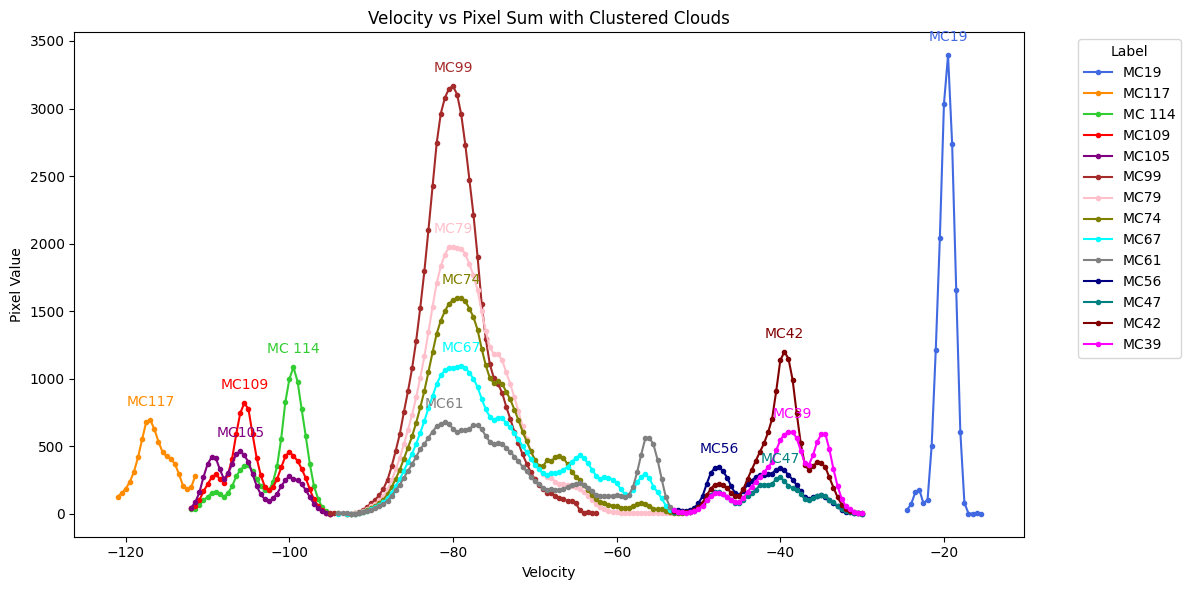

In [42]:
p = [{'bandwidths': [0.1, 0.1, 0.1, 0.1],
      'alpha': 0.8, 'beta': 0.1,
      'method': 'gaussian_kernel',
      'velocity_weight': 5,
      'pixel_value_weight': 1,
      'xy_weight': 1},

     {'bandwidths': [0.1, 0.1, 0.1, 0.1, 0.1],
      'alpha': 0.8, 'beta': 0.1,
      'method': 'gaussian_kernel',
      'velocity_weight': 5.5,
      'pixel_value_weight': 1,
      'xy_weight': 1},

     {'bandwidths': [0.1, 0.1, 0.1],
      'alpha': 0.8, 'beta': 0.1,
      'method': 'gaussian_kernel',
      'velocity_weight': 5.0,
      'pixel_value_weight': 1,
      'xy_weight': 1},

     {'bandwidths': [0.1, 0.1],
      'alpha': 0.8, 'beta': 0.2,
      'method': 'gaussian_kernel',
      'velocity_weight': 14.5,
      'pixel_value_weight': 3.8,
      'xy_weight': 1}]

method = "MS"
CO = "12CO"

df_agg = prepare_results(method,CO,p)
visualize_result(df_agg)

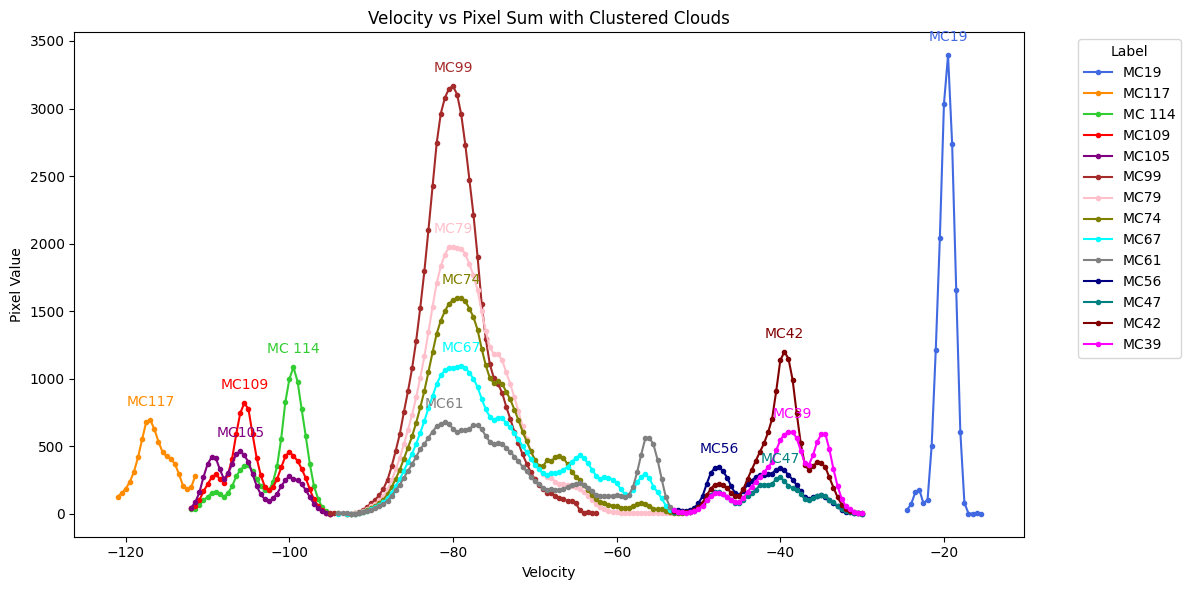

In [41]:
visualize_result(df_agg)

In [32]:
df_agg

,label,velocity,pixel_value,normalized_pixel_sum
0,0,-24.5,29.077888,0.026877
1,0,-24.0,73.700244,0.069521
2,0,-23.5,159.508256,0.151526
3,0,-23.0,176.633773,0.167892
4,0,-22.5,76.749204,0.072435
...,...,...,...,...
727,13,-32.0,56.143521,0.147993
728,13,-31.5,32.340014,0.083559
729,13,-31.0,16.227542,0.039944
730,13,-30.5,8.424387,0.018821


from matplotlib import pyplot as plt
df_agg['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_agg['velocity'].plot(kind='hist', bins=20, title='velocity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_agg['pixel_value'].plot(kind='hist', bins=20, title='pixel_value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_agg['normalized_pixel_sum'].plot(kind='hist', bins=20, title='normalized_pixel_sum')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_agg.plot(kind='scatter', x='label', y='velocity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_agg.plot(kind='scatter', x='velocity', y='pixel_value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_agg.plot(kind='scatter', x='pixel_value', y='normalized_pixel_sum', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['label']
  ys = series['velocity']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_agg.sort_values('label', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('velocity')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['label']
  ys = series['pixel_value']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_agg.sort_values('label', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('pixel_value')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['label']
  ys = series['normalized_pixel_sum']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_agg.sort_values('label', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('normalized_pixel_sum')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['label']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'label'}, axis=1)
              .sort_values('label', ascending=True))
  xs = counted['label']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_agg.sort_values('label', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
df_agg['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_agg['velocity'].plot(kind='line', figsize=(8, 4), title='velocity')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_agg['pixel_value'].plot(kind='line', figsize=(8, 4), title='pixel_value')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_agg['normalized_pixel_sum'].plot(kind='line', figsize=(8, 4), title='normalized_pixel_sum')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
seeds_list = [ [[ 2, 18, -20, 16.267826 ]],

               [[36, 28, -117, 4.000822],
                [3, 34, -114, 44.590847	]],

                [[2, 35, -100,   5.597802],
                 [34, 22, -105,  6.21070 ],
                 [24, 2, -109,  6.593767 ]],

               [[5, 2, -80, 11.789562	  ],
                [18, 95, -73, 3.884139	  ],
                [26, 40, -68, 10.8933067 ],
                [12, 14, -61, 4.530908		],
                [6, 13, -56, 4.385234    ]],

               [[13, 42, -47, 4.081348 ],
                [11, 43, -42, 6.984776	],
                [20, 27, -39, 2.355332 ],
                [12, 1, -35, 2.021111  ]]]

intervals_list = [[-25, -15],[-121, -111.5],[-112, -95],[-95, -52,],[-53, -30]]

otsu_factor_list = [0.2,0.3,0.5,0.25,0.6]

In [ ]:
fits_path = "/content/drive/MyDrive/DSH_RESULTS/4U1630_12CO.fits"

scaled_dataset, scaler, original_dataset = prepare_data(fits_path, -121, -112,
                                                          use_otsu=True, otsu_mult_factor=0.2,
                                                            scaling_method='standard')
scaled_seeds = scale_seeds(seeds_list[1], scaler)

labels = cluster_with_GMM(scaled_dataset, len(scaled_seeds), tol, wghts, scaled_seeds, alpha, beta)


if len(original_dataset) == len(labels):
    result_df = pd.concat([original_dataset, labels], axis=1)
else:
    print("Number of rows in df1 and df2 do not match.")
    exit

agg_df2 = post_process_data_optimized(result_df)

(0.31327064580350383, -117.0, 3.15)
(0.20894931421944332, -114.0, 2.5)
(0.4298328475778421, -109.0, 3.0)
(0.7048214103030962, -105.5, 3.0)
(0.7551411564937404, -99.5, 4.0)
(3.2401527428683927, -80.0, 9.0)
(0.52, -74.0, 4.0)
(0.6189744061235801, -67.5, 10.0)
(0.25, -61.0, 2.0)
(0.44550269392470787, -56.5, 4.0)
(0.4016194616369327, -47.5, 4.5)
(0.5235032811559645, -42.5, 2.5)
(0.9111461622145292, -39.5, 3.5)
(0.5224152038057177, -35.0, 4.0)
(1.5, -19.5, 2.5)


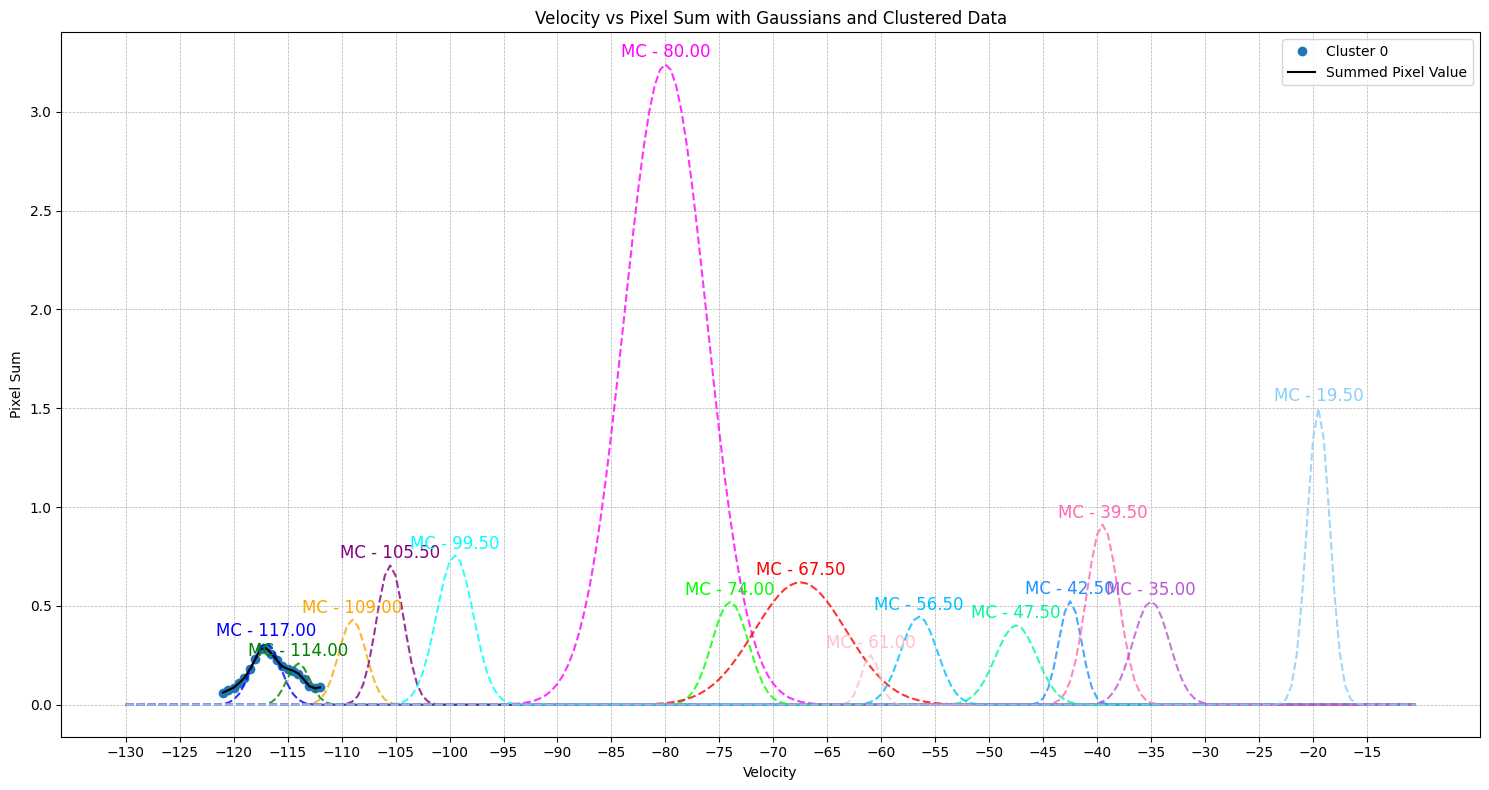

,x,y,velocity,pixel_value,label
8030,1.0,30.0,-121.0,0.218804,0
8031,1.0,30.0,-121.0,0.218804,1
8032,1.0,32.0,-121.0,0.282028,0
8033,1.0,32.0,-121.0,0.282028,1
8034,1.0,33.0,-121.0,0.282028,0
...,...,...,...,...,...
14817,51.0,5.0,-112.0,0.222150,1
14818,51.0,6.0,-112.0,0.129927,0
14819,51.0,6.0,-112.0,0.129927,1
14820,51.0,12.0,-112.0,0.112529,0


In [131]:
bw = [2, 2]
alpha = 0.8
beta = 0.2
vw = 18,
pw = 3.8
xyw = 1

fits_path = "/content/drive/MyDrive/DSH_RESULTS/4U1630_12CO.fits"

scaled_dataset, scaler, original_dataset = prepare_data(fits_path, -121, -112,
                                                          use_otsu=True, otsu_mult_factor=0.2,
                                                            scaling_method='standard')
scaled_seeds = scale_seeds(seeds_list[1], scaler)

labels = multi_label_mean_shift(scaled_dataset, scaled_seeds,
                                bw,alpha=alpha, beta=beta,
                                fweight_velocity=vw, fweight_pixel_value=pw,
                                fweight_xy=xyw)

if len(original_dataset) == len(labels):
    result_df = pd.concat([original_dataset, labels], axis=1)
else:
    print("Number of rows in df1 and df2 do not match.")
    exit

agg_df = post_process_data_optimized(result_df)
visualize_result(agg_df,show_sum=True)

In [46]:
scaled_seeds


array([[ 0.92031454,  0.6176542 , -0.13716678,  6.62431005],
       [-1.40980217,  1.10316399,  1.12457749, 82.82695533]])

In [ ]:
compare_one_method("MS",CO="12CO",best_num=10,error_type="shape_smoothness")

In [ ]:
compare_one_method("GMM",CO="12CO",best_num=10,error_type="ge")

In [ ]:
compare_one_method("GMM",CO="12CO",best_num=10,error_type="ge_normalized")

In [ ]:
compare_one_method("GMMwD",CO="12CO",best_num=10,error_type="ge_normalized")

In [ ]:
compare_one_method("MS",CO="12CO",best_num=10,error_type="intensity_gradient_error")

In [ ]:
compare_one_method("MS",CO="12CO",best_num=10,error_type="intensity_variance_error")

In [ ]:
scaled_seeds

In [109]:
def aggregate_data(dataset, labels):

  df = pd.DataFrame(dataset, columns=['x', 'y', 'velocity', 'pixel_value'])
  df['label'] = labels

  new_rows_list = []

  for index, row in df.iterrows():

      if len(row['label']) == 1:
          single_label = row['label'][0]
          if isinstance(single_label, tuple):
            df.at[index, 'label'] = int(single_label[0])
          else:
            df.at[index, 'label'] = int(single_label)
      else:
          for item in row['label']:
              new_row = row.copy()
              new_row['label'] = item[0]
              new_row['pixel_value'] *= item[1]
              new_rows_list.append(new_row)

          df.drop(index, inplace=True)

  # Create a new DataFrame from the list of new rows
  new_rows_df = pd.DataFrame(new_rows_list)

  # Concatenate the original DataFrame and the new rows, then reset the index
  df = pd.concat([df, new_rows_df]).reset_index(drop=True)

  # Sort by 'velocity'
  df.sort_values(by=['velocity','x'], inplace=True)
  norm_range = [0, 3.2428885]
  min_pixel_sum = 3.292444457284546
  max_pixel_sum = 8442.390370830894


  aggregated = df.groupby(['velocity', 'label'])['pixel_value'].sum().reset_index()

  aggregated['pixel_value'] = norm_range[0] + ((aggregated['pixel_value'] - min_pixel_sum) * (norm_range[1] - norm_range[0]) / (max_pixel_sum - min_pixel_sum))

  total_sum_by_velocity = df.groupby('velocity')['pixel_value'].sum().reset_index()

  total_sum_by_velocity['pixel_value'] = norm_range[0] + ((total_sum_by_velocity['pixel_value'] - min_pixel_sum) * (norm_range[1] - norm_range[0]) / (max_pixel_sum - min_pixel_sum))
  total_sum_by_velocity['label'] = 'total'
  aggregated = pd.concat([aggregated, total_sum_by_velocity], ignore_index=True)

  return aggregated,df

In [102]:



def plot_spectrum(dataset,labels, show_sum = False):

    aggregated,df = aggregate_data(dataset, labels)
    filtered_agg = aggregated[aggregated['label'] == 'total']
    aggregated = aggregated[aggregated['label'] != 'total']

    velocities = np.array(np.arange(-130, -10, 0.5))

    # Plotting
    plt.figure(figsize=(15, 8))
    plot_gaussians(velocities, gaussian_parameters, agg_data=aggregated)

    # Remaining plot adjustments
    plt.xlabel('Velocity')
    plt.ylabel('Pixel Sum')
    plt.title('Velocity vs Pixel Sum with Gaussians and Clustered Data')
    plt.xticks(np.arange(-130, -10, 5))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df

def plot_gaussians(velocities, gaussian_params, agg_data=None):
    # Bright colors list with 15 colors
    colors = ['blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'red', 'pink', 'deepskyblue',
              'mediumspringgreen', 'dodgerblue', 'hotpink', 'mediumorchid', 'lightskyblue']

    # If aggregated data is provided, plot it
    if agg_data is not None:
        for label, group in agg_data.groupby('label'):
            plt.plot(group['velocity'], group['pixel_value'], 'o', label=f'Cluster {label}')

    for i, (amplitude, center, FWHM) in enumerate(gaussian_params):
        print((amplitude, center, FWHM))
        sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
        y_values = amplitude * np.exp(-(velocities - center)**2 / (2 * sigma**2))

        # Plot the Gaussian
        plt.plot(velocities, y_values, linestyle='--', color=colors[i % len(colors)], alpha=0.8)

        # Annotate the peak with the center velocity value
        peak_y = amplitude  # the peak y value for a Gaussian is its amplitude
        plt.annotate(f"MC - {abs(center):.2f}", (center, peak_y), textcoords="offset points", xytext=(0,5), ha='center', color=colors[i % len(colors)], fontsize=12)


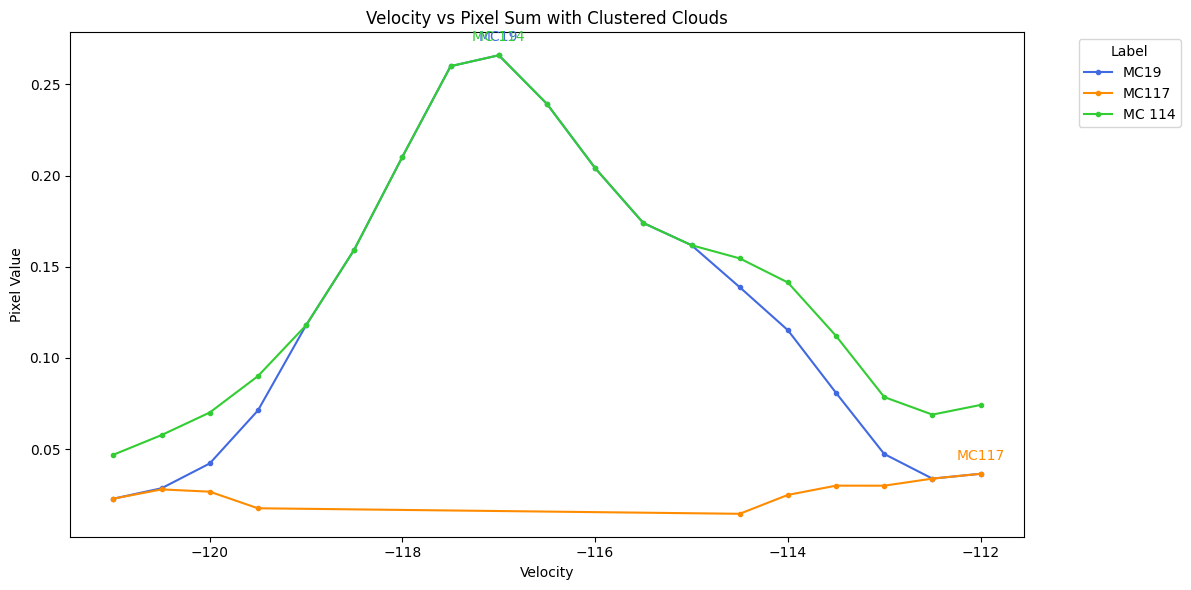

(0.31327064580350383, -117.0, 3.15)
(0.20894931421944332, -114.0, 2.5)
(0.4298328475778421, -109.0, 3.0)
(0.7048214103030962, -105.5, 3.0)
(0.7551411564937404, -99.5, 4.0)
(3.2401527428683927, -80.0, 9.0)
(0.52, -74.0, 4.0)
(0.6189744061235801, -67.5, 10.0)
(0.25, -61.0, 2.0)
(0.44550269392470787, -56.5, 4.0)
(0.4016194616369327, -47.5, 4.5)
(0.5235032811559645, -42.5, 2.5)
(0.9111461622145292, -39.5, 3.5)
(0.5224152038057177, -35.0, 4.0)
(1.5, -19.5, 2.5)


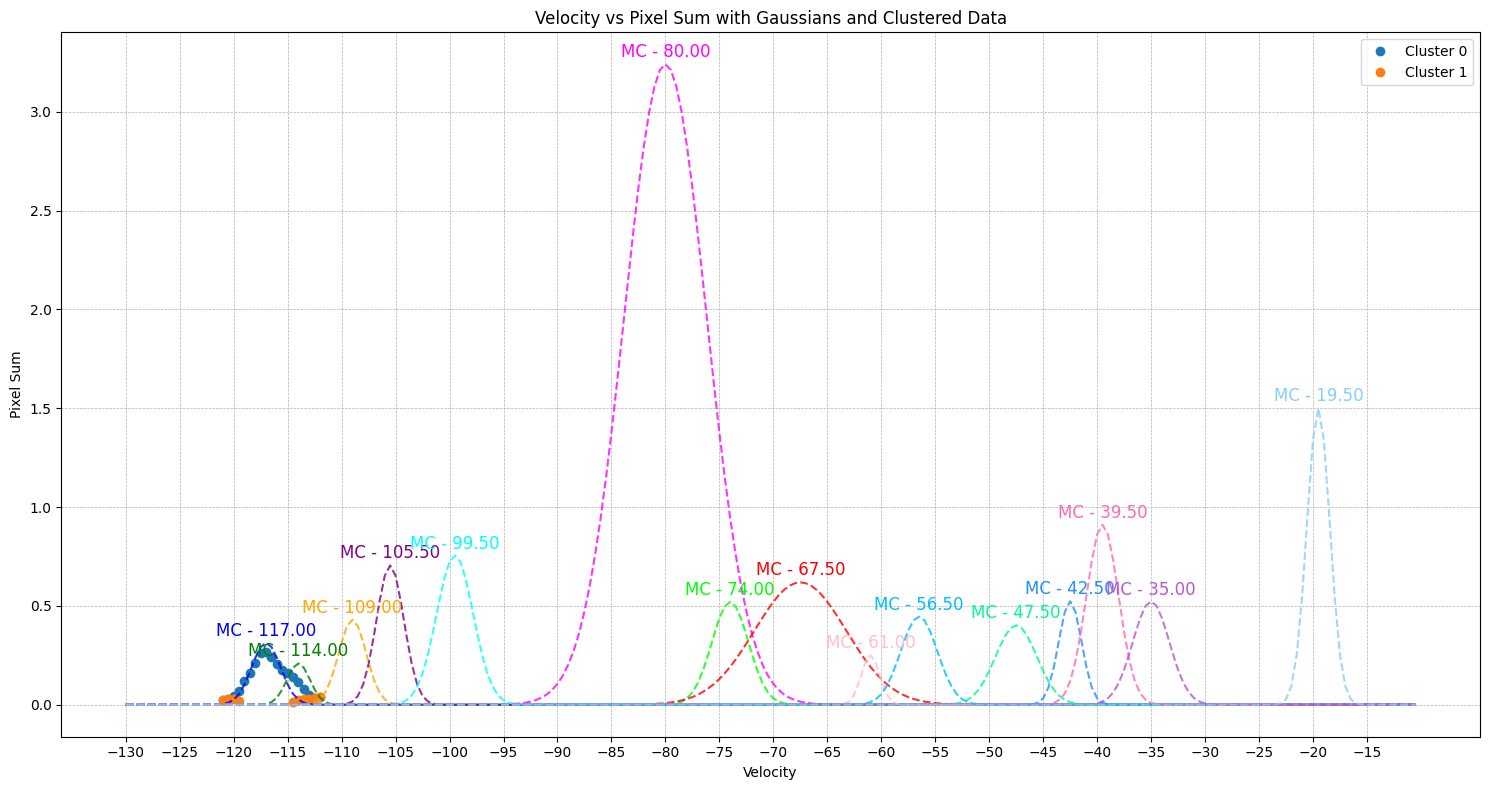

,x,y,velocity,pixel_value,label
8030,1.0,30.0,-121.0,0.218804,0
8031,1.0,30.0,-121.0,0.218804,1
8032,1.0,32.0,-121.0,0.282028,0
8033,1.0,32.0,-121.0,0.282028,1
8034,1.0,33.0,-121.0,0.282028,0
...,...,...,...,...,...
14817,51.0,5.0,-112.0,0.222150,1
14818,51.0,6.0,-112.0,0.129927,0
14819,51.0,6.0,-112.0,0.129927,1
14820,51.0,12.0,-112.0,0.112529,0


In [110]:
fits_path = "/content/drive/MyDrive/DSH_RESULTS/4U1630_12CO.fits"

bw = [2, 2]
alpha = 0.8
beta = 0.2
vw = 14.5
pw = 3.8
xyw = 1

scaled_dataset, scaler, original_dataset = prepare_data(fits_path, -121, -112,
                                                          use_otsu=True, otsu_mult_factor=0.3,
                                                            scaling_method='standard')
scaled_seeds = scale_seeds(seeds_list[1], scaler)

C, labels, A, B = multi_label_mean_shift1(scaled_dataset, scaled_seeds, bw, epsilon=1e-3, max_iter=100,
                           weighting_method='gaussian_kernel', alpha=alpha, beta=beta, fweight_velocity=vw,fweight_pixel_value=pw,fweight_xy=xyw)

#labels_df = pd.DataFrame({'label': labels})

aggregated,df = aggregate_data(original_dataset, labels)

#agg_df = post_process_data_optimized(result_df)
visualize_result(aggregated)


plot_spectrum(original_dataset,labels)

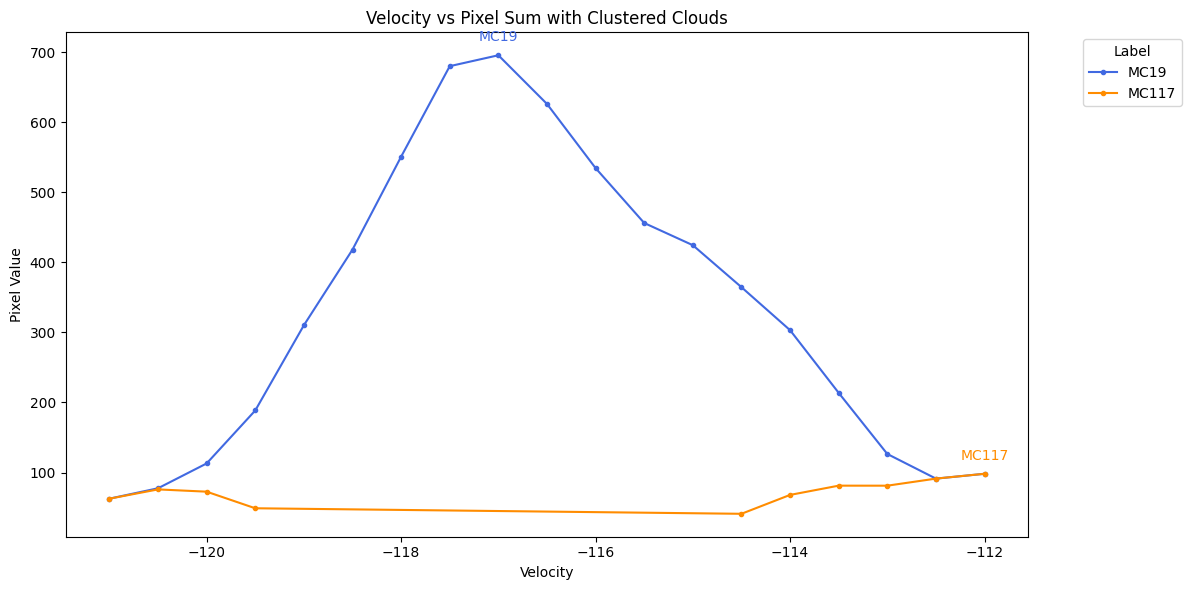

(0.31327064580350383, -117.0, 3.15)
(0.20894931421944332, -114.0, 2.5)
(0.4298328475778421, -109.0, 3.0)
(0.7048214103030962, -105.5, 3.0)
(0.7551411564937404, -99.5, 4.0)
(3.2401527428683927, -80.0, 9.0)
(0.52, -74.0, 4.0)
(0.6189744061235801, -67.5, 10.0)
(0.25, -61.0, 2.0)
(0.44550269392470787, -56.5, 4.0)
(0.4016194616369327, -47.5, 4.5)
(0.5235032811559645, -42.5, 2.5)
(0.9111461622145292, -39.5, 3.5)
(0.5224152038057177, -35.0, 4.0)
(1.5, -19.5, 2.5)


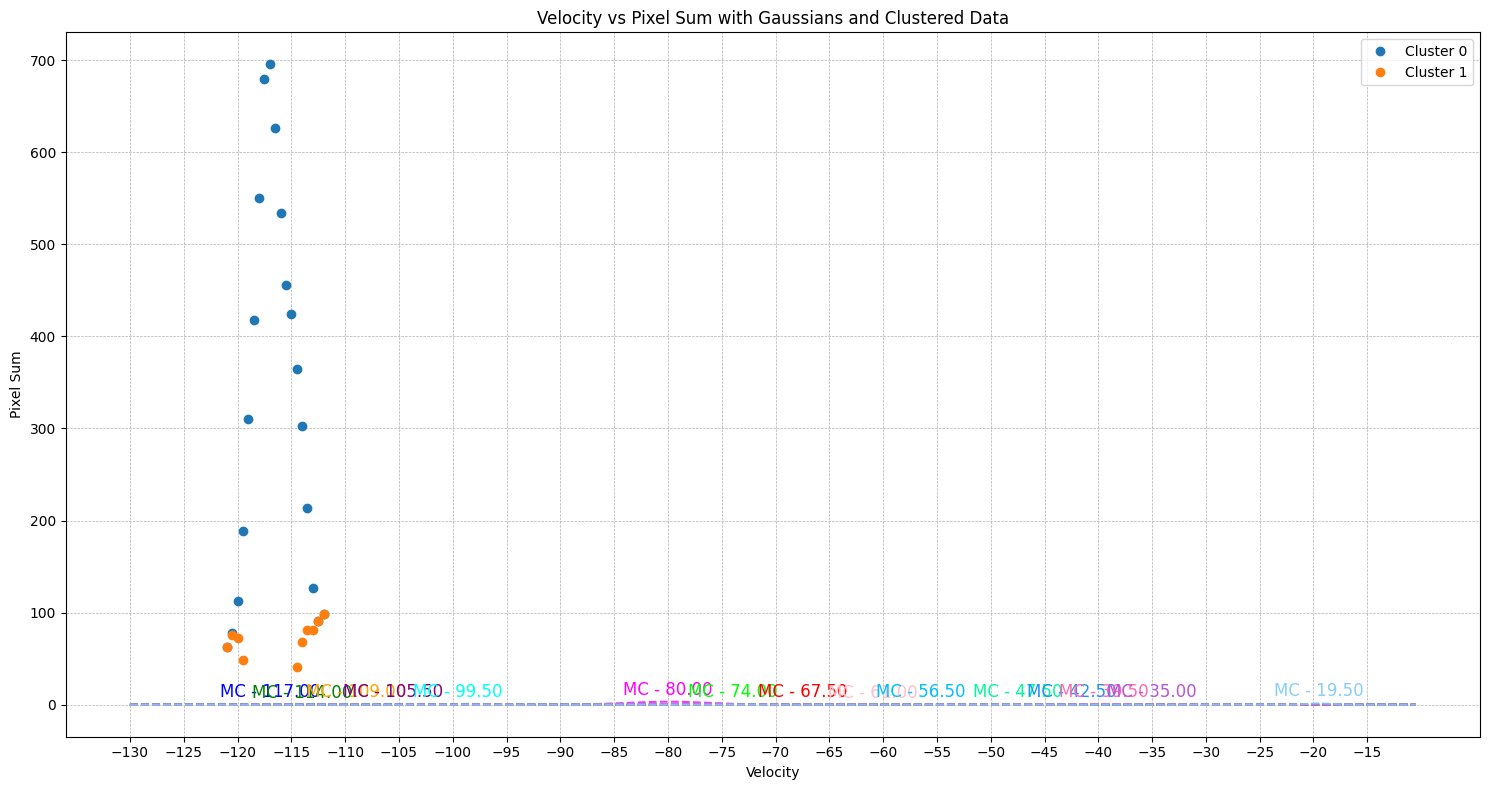

,x,y,velocity,pixel_value,label
8030,1.0,30.0,-121.0,0.218804,0
8031,1.0,30.0,-121.0,0.218804,1
8032,1.0,32.0,-121.0,0.282028,0
8033,1.0,32.0,-121.0,0.282028,1
8034,1.0,33.0,-121.0,0.282028,0
...,...,...,...,...,...
14817,51.0,5.0,-112.0,0.222150,1
14818,51.0,6.0,-112.0,0.129927,0
14819,51.0,6.0,-112.0,0.129927,1
14820,51.0,12.0,-112.0,0.112529,0


In [112]:
fits_path = "/content/drive/MyDrive/DSH_RESULTS/4U1630_12CO.fits"

bw = [2, 2]
alpha = 0.8
beta = 0.2
vw = 14.5
pw = 3.8
xyw = 1

scaled_dataset, scaler, original_dataset = prepare_data(fits_path, -121, -112,
                                                          use_otsu=True, otsu_mult_factor=0.3,
                                                            scaling_method='standard')
scaled_seeds = scale_seeds(seeds_list[1], scaler)

C, labels, A, B = multi_label_mean_shift1(scaled_dataset, scaled_seeds, bw, epsilon=1e-3, max_iter=100,
                           weighting_method='gaussian_kernel', alpha=alpha, beta=beta, fweight_velocity=vw,fweight_pixel_value=pw,fweight_xy=xyw)

labels_df = pd.DataFrame({'label': labels})

if len(original_dataset) == len(labels_df):
    result_df = pd.concat([original_dataset, labels_df], axis=1)
else:
    print("Number of rows in df1 and df2 do not match.")
    exit

agg_df = post_process_data_optimized(result_df)
visualize_result(agg_df)
plot_spectrum2(agg_df)

In [91]:
aggregated

,velocity,label,pixel_value
0,-121.0,0,54.643688
1,-121.0,1,53.637498
2,-120.5,0,66.467875
3,-120.5,1,62.964950
4,-120.0,0,89.858635
5,-120.0,1,61.456231
6,-119.5,0,126.568371
7,-119.5,1,64.874728
8,-119.0,0,183.352330
9,-119.0,1,54.168308


In [63]:
labels

[[(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5), (1, 0.5)],
 [(0, 0.5),

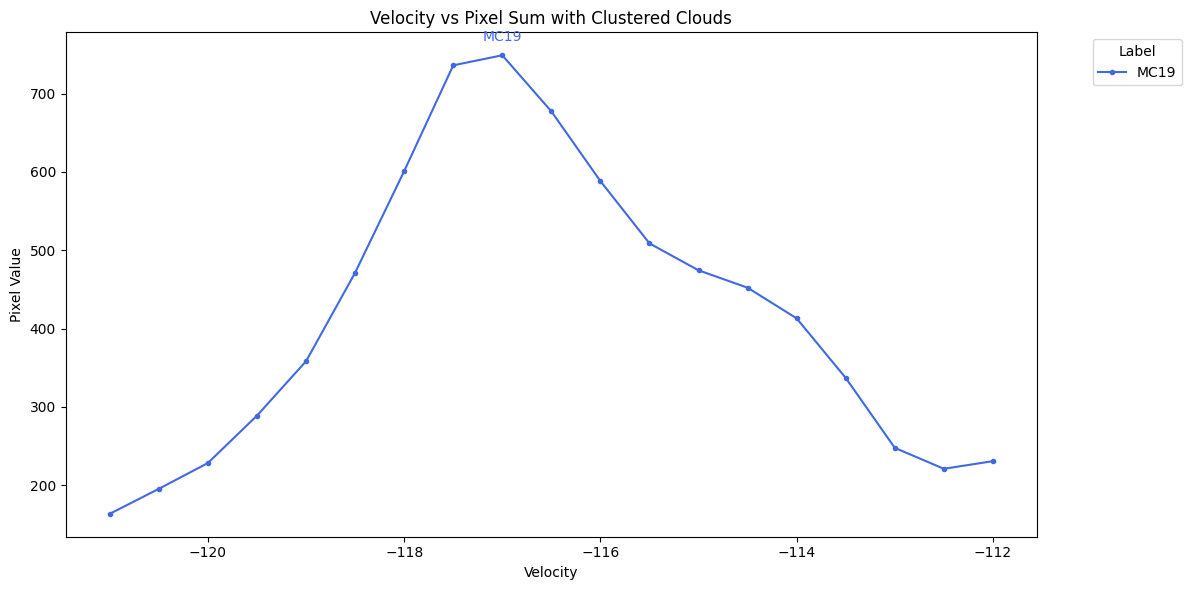

In [55]:
if len(original_dataset) == len(labels):
    result_df = pd.concat([original_dataset, labels], axis=1)
else:
    print("Number of rows in df1 and df2 do not match.")
    exit

agg_df = post_process_data_optimized(result_df)
visualize_result(agg_df)

In [ ]:
mean_shift_clustering(X, seeds, bandwidths, epsilon=1e-3, max_iter=10, fweight_velocity=1, fweight_pixel_value=1, fweight_xy=1):

In [53]:
def mean_shift_clustering1(X, seeds, bandwidths, epsilon=1e-3, max_iter=10, fweight_velocity=1, fweight_pixel_value=1, fweight_xy=1):
    """
    Modified Mean Shift Clustering Algorithm with weighted velocity.

    Parameters:
        X (array): Data points as a 2D NumPy array, shape (n_samples, n_features)
        seeds (array): Initial seed points as a 2D NumPy array, shape (n_clusters, n_features)
        bandwidths (array): Bandwidths for each seed point as a 1D NumPy array, shape (n_clusters,)
        weight_velocity (float): Weight to apply to the velocity feature
        epsilon (float): Convergence threshold
        max_iter (int): Maximum number of iterations

    Returns:
        C (array): Cluster centers, shape (n_clusters, n_features)
        labels (array): Cluster labels for each data point, shape (n_samples,)
        A (array): Distance matrix, shape (n_samples, n_clusters)
    """

    weight_velocity = fweight_velocity
    weight_pixel_value = fweight_pixel_value
    weight_xy = fweight_xy

    # Weight the velocity feature
    X_weighted = np.copy(X)
    seeds_weighted = np.copy(seeds)

    # Assuming velocity is the third column (0-indexed)
    X_weighted[:, 0] *= weight_xy
    seeds_weighted[:, 0] *= weight_xy
    X_weighted[:, 1] *= weight_xy
    seeds_weighted[:, 1] *= weight_xy

    # Assuming velocity is the third column (0-indexed)
    X_weighted[:, 2] *= weight_velocity
    seeds_weighted[:, 2] *= weight_velocity

    # Assuming velocity is the third column (0-indexed)
    X_weighted[:, 3] *= weight_pixel_value
    seeds_weighted[:, 3] *= weight_pixel_value


    # Initialize cluster centers as seeds
    C = np.copy(seeds_weighted)

    # Initialize distance matrix A
    n_samples, n_features = X.shape
    n_clusters = len(seeds)
    A = np.zeros((n_samples, n_clusters))

    # Main loop for each seed point
    for i in range(n_clusters):
        s_i = seeds_weighted[i]
        b_i = bandwidths[i]
        for _ in range(max_iter):
            # Initialize neighbors within bandwidth
            N = []
            for x_j in X_weighted:
                d = euclidean(s_i, x_j)
                if d < b_i:
                    N.append(x_j)

            if len(N) == 0:
                break

            # Calculate the shift vector M
            N = np.array(N)
            weights = np.exp(-np.sum((N - s_i)**2, axis=1) / (2 * b_i**2))
            M = np.sum(weights[:, None] * N, axis=0) / np.sum(weights)

            # Check for convergence
            if euclidean(s_i, M) < epsilon:
                break

            # Update the seed point
            s_i = M

        # Update cluster center
        C[i] = s_i

    # Fill distance matrix A and assign clusters
    labels = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        for j in range(n_clusters):
            A[i, j] = euclidean(X_weighted[i], C[j])
        labels[i] = np.argmin(A[i])

    # Revert the weighting on the final cluster centers for interpretability
    C[:, 2] /= weight_velocity
    C[:, 3] /= weight_pixel_value

    return C, labels, A

In [54]:
def calculate_B_matrix1(A, method='inverse_distance'):
    """
    Calculate the B matrix from the A distance matrix using different methods.

    Parameters:
        A (array): Distance matrix, shape (n_samples, n_clusters)
        method (str): Method for calculating B, one of ['inverse_distance', 'gaussian_kernel', 'softmax']

    Returns:
        B (array): Matrix with percentage of each data point belonging to each cluster, shape (n_samples, n_clusters)
    """
    n_samples, n_clusters = A.shape
    B = np.zeros((n_samples, n_clusters))

    for i in range(n_samples):
        if method == 'inverse_distance':
            B[i, :] = 1 / A[i, :]
            B[i, :] /= np.sum(B[i, :])

        elif method == 'gaussian_kernel':
            B[i, :] = np.exp(-A[i, :] ** 2)
            if np.sum(B[i, :]) == 0:
                B[i, :] = 1.0 / len(B[i, :])  # Uniform distribution across clusters
            else:
                B[i, :] /= np.sum(B[i, :])

        elif method == 'softmax':
            B[i, :] = np.exp(-A[i, :])
            B[i, :] /= np.sum(B[i, :])

    return B

In [52]:
def multi_label_mean_shift1(X, seeds, bandwidths, epsilon=1e-3, max_iter=100,
                           weighting_method='inverse_distance', alpha=0.6, beta=0.1, fweight_velocity=1,fweight_pixel_value=1,fweight_xy=1):
    """
    Multi-label Mean Shift clustering with soft assignments.

    Parameters:
        All parameters from mean_shift_clustering
        weighting_method (str): Method for calculating B matrix, one of ['inverse_distance', 'gaussian_kernel', 'softmax']
        alpha (float): Threshold for max probability to assign single label
        beta (float): Threshold for minimum probability to consider for multi-label assignment

    Returns:
        C (array): Cluster centers, shape (n_clusters, n_features)
        labels (list): Cluster labels for each data point, can be multi-label
        A (array): Distance matrix, shape (n_samples, n_clusters)
        B (array): Soft assignment matrix, shape (n_samples, n_clusters)
    """

    # First, run the modified mean_shift_clustering to get C, labels, and A
    C, _, A = mean_shift_clustering1(X, seeds, bandwidths, epsilon, max_iter, fweight_velocity, fweight_pixel_value,fweight_xy)

    # Calculate B matrix based on A and the selected weighting method
    B = calculate_B_matrix1(A, method=weighting_method)

    # Initialize labels list
    labels = []

    # Assign labels based on B matrix, alpha and beta
    for i in range(len(X)):
        max_prob = np.max(B[i])
        if max_prob >= alpha:
            # Assign the single label corresponding to max probability
            labels.append([np.argmax(B[i])])
        else:
            # Find the probabilities above and below the beta threshold
            above_beta_indices = np.where(B[i] >= beta)[0]
            below_beta_indices = np.where(B[i] < beta)[0]

            # Sum up the probabilities below the beta threshold
            sum_below_beta = np.sum(B[i, below_beta_indices])

            # Redistribute the summed probabilities to those above beta, based on their existing values
            sum_above_beta = np.sum(B[i, above_beta_indices])
            redistributed_probs = B[i, above_beta_indices] + (B[i, above_beta_indices] / sum_above_beta) * sum_below_beta

            # Create a list of tuples containing the cluster label and its updated probability
            updated_labels_probs = list(zip(above_beta_indices, redistributed_probs))

            # Ensure the probabilities sum up to 1 (due to numerical inaccuracies)
            total_prob = sum(prob for label, prob in updated_labels_probs)
            updated_labels_probs = [(label, prob / total_prob) for label, prob in updated_labels_probs]

            labels.append(updated_labels_probs)

            if updated_labels_probs == []:
              print("max",max_prob," matrix",B[i]," redistributedprobs",redistributed_probs," updatedprobs",updated_labels_probs,"total",total_prob)


    return C, labels, A, B
